In [33]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import tumour_model as tm
import scheduler as sch

In [34]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
print("patient config:", patient_config)
doses = [1, 0.75, 0.5]

{'start_size': 10000000.0, 'start_toxicity': 0.5, 'start_strike': 1, 'start_cycle': 1}


In [22]:
allele_shape_param = 1

def cost(toxicity, plan, schedule):
    return random.random()

def benefit(burden, plan, schedule):
    duration = sch.duration(schedule)
    sol = tm.tumour_growth(burden, duration, schedule, allele_shape_param, plan, duration)
    size = tm.final_tumour_volume(sol)
    return size

def score(config, plan):
    sch_list = sch.plan_to_schedule(*plan, config["start_strike"], config["start_cycle"])
    schedule = np.array(sch_list, dtype=object)
    cost_val = cost(config["toxicity"], plan, schedule)
    benefit_val = max(1 - benefit(config["burden"], plan, schedule), 0)
    return cost_val, benefit_val

def score_total(cost, benefit):
    return benefit - cost

In [23]:
start_time = time.time()

all_plans = [(t1, t2, t3, t4) for t1 in doses for t2 in doses for t3 in doses for t4 in doses]

scored_plans = [(*plan, *score(patient_config, plan)) for plan in all_plans]

df_sch = pd.DataFrame(scored_plans, columns = ["t1", "t2", "t3", "t4", "cost", "benefit"])
df_sch.head()

# add total score column
df_sch["total_score"] = df_sch.apply(lambda x: score_total(x["cost"], x["benefit"]), axis=1)

# find best schedule as the maximum total score
best_schedule = df_sch.loc[df_sch["total_score"].idxmax()]

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tested {len(df_sch)} treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")
print(f"Best schedule:\n{best_schedule.iloc[0:4]}\nCost: {best_schedule['cost']:.4f}\nBenefit: {best_schedule['benefit']:.4f}")

Tested 81 treatment schedules.
Elapsed Time: 50.9769 seconds
Best schedule:
t1    1.00
t2    0.75
t3    0.75
t4    0.75
Name: 13, dtype: float64
Cost: 0.0044
Benefit: 1.0000


In [24]:
df_sch.head()

,t1,t2,t3,t4,cost,benefit,total_score
0,1.0,1.0,1.00,1.00,0.794117,1.0,0.205883
1,1.0,1.0,1.00,0.75,0.676631,1.0,0.323369
2,1.0,1.0,1.00,0.50,0.256588,1.0,0.743412
3,1.0,1.0,0.75,1.00,0.751846,1.0,0.248154
4,1.0,1.0,0.75,0.75,0.581848,1.0,0.418152


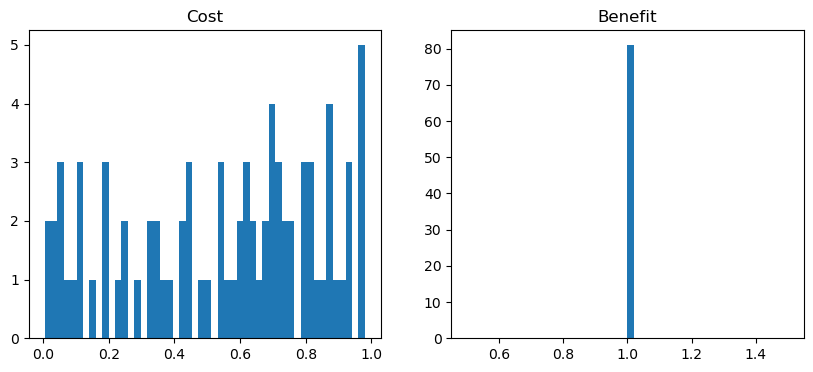

In [25]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df_sch["cost"], bins=50)
ax[0].set_title("Cost");
ax[1].hist(df_sch["benefit"], bins=50)
ax[1].set_title("Benefit");

Text(0.5, 1.0, 'Cost vs Benefit for All Treatment Schedules')

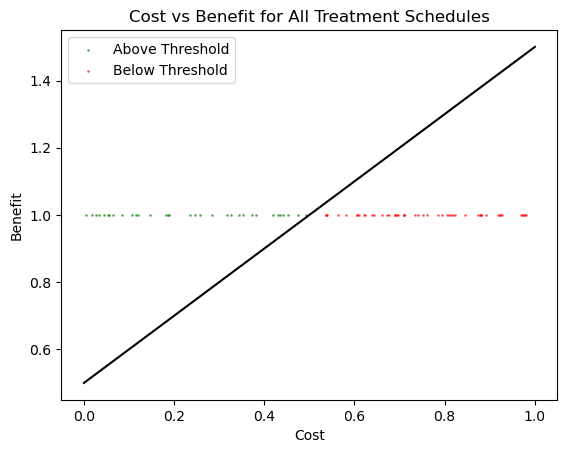

In [26]:
threshold = 0.5 # arbitrary threshold

above_threshold = df_sch.loc[df_sch["total_score"] > threshold]
below_threshold = df_sch.loc[df_sch["total_score"] <= threshold]
plt.scatter(above_threshold["cost"], above_threshold["benefit"], s=1, alpha=0.5, c="green", label="Above Threshold")
plt.scatter(below_threshold["cost"], below_threshold["benefit"], s=1, alpha=0.5, c="red", label="Below Threshold")

# add a line at y = x - 1.5
x = np.linspace(0, 1, 100)
y = x + threshold
plt.plot(x, y, c="black")

plt.xlabel("Cost")
plt.ylabel("Benefit")
plt.legend()
plt.title("Cost vs Benefit for All Treatment Schedules")